In [1]:
import os
import time
import math

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gym

In [3]:
env_name = 'Breakout-v0'
env = gym.make(env_name)

In [4]:
env.action_space.sample()

3

In [5]:
env.action_space.n

4

In [6]:
env.observation_space.shape

(210, 160, 3)

In [7]:
state = env.reset()
state.shape

(210, 160, 3)

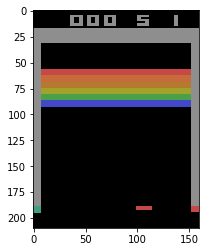

In [8]:
plt.imshow(state)

In [9]:
gray = np.mean(state, axis=2)
gray.shape

(210, 160)

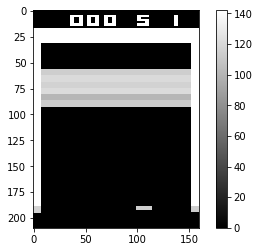

In [10]:
plt.imshow(gray, cmap='gray')
plt.colorbar()

In [11]:
down_sample = gray[::2, ::2]
down_sample.shape

(105, 80)

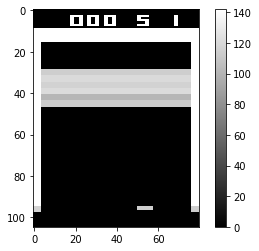

In [12]:
plt.imshow(down_sample, cmap='gray')
plt.colorbar()

In [13]:
def process_image(img):
    _img = np.mean(img, axis=2, dtype=np.uint8)
    _img = _img[::2, ::2]
    return _img

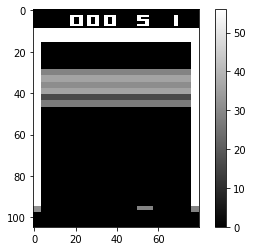

In [15]:
plt.imshow(process_image(state), cmap='gray')
plt.colorbar()

In [16]:
_state = process_image(state)
_state.shape

(105, 80)

In [17]:
state.dtype

dtype('uint8')

In [18]:
_state.dtype

dtype('uint8')

In [19]:
state_memory = []

In [20]:
for _ in range(64):
    action = env.action_space.sample()
    observation = env.step(action)
    state, reward, done, info = observation
    _state = process_image(state)
    state_memory.append(_state)

In [21]:
len(state_memory)

64

In [22]:
idx = 0

7


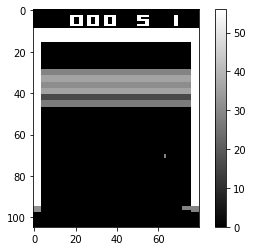

In [29]:
idx %= len(state_memory)
idx += 1
print(idx)
plt.imshow(state_memory[idx], cmap='gray')
plt.colorbar()

In [30]:
seq_states = np.array(state_memory[20:30])
seq_states.shape

(10, 105, 80)

In [31]:
seq_states.dtype

dtype('uint8')

In [32]:
max_seq_states = np.max(seq_states, axis=0)
max_seq_states.shape

(105, 80)

In [33]:
max_seq_states.dtype

dtype('uint8')

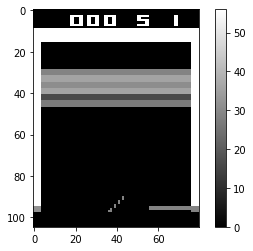

In [34]:
plt.imshow(max_seq_states, cmap='gray')
plt.colorbar()

In [35]:
process_seq_state = []

for idx, s in enumerate(seq_states):
    # fade past images
    alpha = idx / len(seq_states)
    s = s * alpha
    process_seq_state.append(s)

process_seq_state = np.array(process_seq_state, dtype=np.uint8)
process_seq_state = np.max(process_seq_state, axis=0)

In [36]:
s.shape

(105, 80)

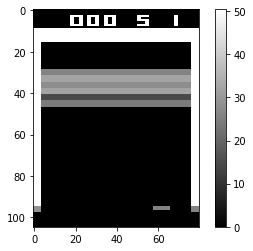

In [38]:
plt.imshow(s, cmap='gray')
plt.colorbar()

In [39]:
process_seq_state.shape

(105, 80)

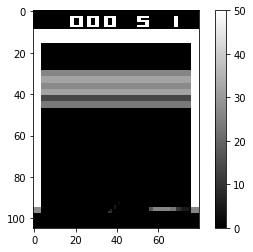

In [40]:
plt.imshow(process_seq_state, cmap='gray')
plt.colorbar()

In [41]:
def ray_trace(seq_images):
    process_seq = []

    for idx, s in enumerate(seq_images):
        s = s * ((idx+1) / len(seq_images))
        process_seq.append(s)
    process_seq = np.array(process_seq, dtype=np.uint8)
    ray_trace_image = np.max(process_seq, axis=0)
    return ray_trace_image

In [43]:
ray_trace_image = ray_trace(state_memory[10:30])
ray_trace_image.shape

(105, 80)

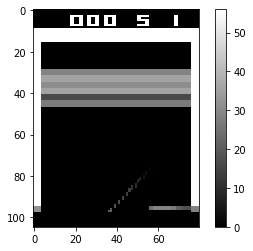

In [44]:
plt.imshow(ray_trace_image, cmap='gray')
plt.colorbar()

**Tranditional Q-Learning update equation**

$Q_{s,a} \leftarrow (1 - \alpha) Q_{s,a} + \alpha (reward + \gamma \max(Q_{s'})$

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

Test unpack `input_shape`

In [45]:
(*(105, 80, 1), )

(105, 80, 1)

In [ ]:
class DQN:
    def __init__(self, input_shape=(105, 80, 1), n_actions=4, lr=0.00001, discount_rate=0.8):
        self.input_shape = input_shape
        self.n_actions = n_actions
        self.model = create_keras_model(input_shape, n_actions)
        self.lr = lr
        self.discount_rate = discount_rate

    def create_keras_model(input_shape, n_actions):
        model = keras.Sequential([
            Conv2D(
                filters=32,
                kernel_size=8,
                strides=4,
                activation='relu',
                input_shape=(*input_shape, ),
                data_format='channels_last',
            ),
            Conv2D(
                filters=64,
                kernel_size=4,
                strides=2,
                activation='relu',
            ),
            Conv2D(
                filters=64,
                kernel_size=3,
                activation='relu',
            ),
            Flatten(),
            Dense(
                units=n_actions,
            ),
        ])
        
        optimizer = Adam(
            learning_rate=self.lr,
        )
        
        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['accuracy',],
        )

        return model

    def reshape_state(self, state):
        """
        `state`: 2D array (height, width)
        """
        return np.reshape(a=state, newshape=(1, *self.input_shape))
    
    def reshape_states(self, states):
        """
        `states`: 3D array (batch_size, height, width)
        """
        return np.reshape(a=states, newshape=(-1, *self.input_shape))

    def update_q_values(self, state, action, reward, new_state):
        # batch the current `state` and the `new_state` together for optimization
        q_batch = np.array([
            state,
            new_state,
        ])
        # reshape the batch
        q_batch = self.reshape_states(q_batch)
        # get the Q-values from the deep neural network
        q_results = self.model.predict(q_batch)
        current_q_values = q_results[0]
        new_state_q_values = q_results[1]
        
        # copy the current Q-values
        target_q_values = current_q_values
        # modify the Q-value of the `action`
        target_q_values[action] = reward + self.discount_rate * np.max(new_state_q_values)

        self.model.fit(
            x=self.reshape_state(state),
            y=target_q_values,
            verbose=0,
        )
    
    def replay_memory(self):
        pass

In [ ]:
state.shape

In [ ]:
ray_trace_image.shape

In [ ]:
(1, *ray_trace_image.shape, 1)